<a href="https://colab.research.google.com/github/yudumpacin/NLPStudyNotes/blob/main/TextClassification_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with BERT via SimpleTransformers

## Get Kaggle data from https://www.kaggle.com/datasets/savasy/ttc4900

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [61]:
df = pd.read_csv("7allV03.csv")

In [62]:
df.head()

,category,text
0,siyaset,3 milyon ile ön seçim vaadi mhp nin 10 olağan...
1,siyaset,mesut_yılmaz yüce_divan da ceza alabilirdi pr...
2,siyaset,disko lar kaldırılıyor başbakan_yardımcısı ar...
3,siyaset,sarıgül anayasa_mahkemesi ne gidiyor mustafa_...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek ...


In [63]:
df.shape

(4900, 2)

In [64]:

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('turkish'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
def preprocess_for_training(text_data):
  text_data = re.sub("[^a-zA-ZğüşöçıİĞÜŞÖÇ0-9.,;:!?'\" ]"," ",text_data)
  text_data = ' '.join([word for word in text_data.split() if word not in stop_words])
  return text_data

In [66]:
df["text"]= df["text"].apply(preprocess_for_training)
df["category"]=df["category"].str.strip()

In [67]:
df.head()

,category,text
0,siyaset,3 milyon ön seçim vaadi mhp nin 10 olağan büyü...
1,siyaset,mesut yılmaz yüce divan ceza alabilirdi prof d...
2,siyaset,disko lar kaldırılıyor başbakan yardımcısı arı...
3,siyaset,sarıgül anayasa mahkemesi gidiyor mustafa sarı...
4,siyaset,erdoğan idamın bir haklılık sebebi var demek y...


In [68]:
df.category.value_counts()

siyaset      700
dunya        700
ekonomi      700
kultur       700
saglik       700
spor         700
teknoloji    700
Name: category, dtype: int64

In [69]:
df["category"]=df["category"].astype("category")

In [70]:
df["category_id"] = df["category"].cat.codes

In [71]:
id_to_category = pd.Series(df["category"].values,index=df["category_id"]).to_dict()

In [72]:
id_to_category

{4: 'siyaset',
 0: 'dunya',
 1: 'ekonomi',
 2: 'kultur',
 3: 'saglik',
 5: 'spor',
 6: 'teknoloji'}

In [73]:
category_to_id = {v:i for i,v in id_to_category.items()}

In [74]:
category_to_id

{'siyaset': 4,
 'dunya': 0,
 'ekonomi': 1,
 'kultur': 2,
 'saglik': 3,
 'spor': 5,
 'teknoloji': 6}

## Train-val-test split

In [75]:
X_train,X_test,y_train,y_test = train_test_split(df["text"],df["category_id"], random_state=0,test_size=0.3,stratify=df["category_id"])


In [76]:

X_test,X_val,y_test,y_val = train_test_split(X_test,y_test, random_state=0,test_size=0.5,stratify=y_test)

In [77]:
data_train = pd.concat([X_train,y_train],axis=1)
data_val = pd.concat([X_val,y_val],axis=1)
data_test = pd.concat([X_test,y_test],axis=1)

## Model




source: https://simpletransformers.ai/docs/multi-class-classification/

In [78]:
pip install simpletransformers

In [79]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [80]:
# Optional model configuration

model_args = ClassificationArgs()
model_args.num_train_epochs = 1
model_args.train_batch_size = 16
model_args.best_model_dir = "outputs/best_model"
model_args.save_eval_checkpoints=False
model_args.save_model_every_epoch=False
model_args.save_optimizer_and_scheduler=False
model_args.overwrite_output_dir = True
model_args.use_multiprocessing = False
model_args.no_cache = False


In [81]:
# Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'dbmdz/bert-base-turkish-uncased',
    num_labels=7,
    args=model_args,
    use_cuda=False
)

# Train the model
model.train_model(data_train)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:611: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/215 [00:00<?, ?it/s]

(215, 0.5894914887239073)

In [82]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(data_val)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/735 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/92 [00:00<?, ?it/s]

In [84]:
import numpy as np
predictions = []
for output in model_outputs:
  pred = np.argmax(output)
  pred_id = id_to_category[pred]
  predictions.append(pred_id)

In [85]:
vals_results = data_val.copy()
vals_results["category"] = data_val.category_id.map(id_to_category)
vals_results["preds"] = predictions

In [86]:
vals_results

,text,category_id,category,preds
2252,shaman dans tiyatrosu lütfi kırdar kongre serg...,2,kultur,kultur
2428,aref ghafouri bostancı gösteri merkezi 25 11 2...,2,kultur,kultur
4344,çocuğu sanal kiralık katil tuttu çin bir baba ...,6,teknoloji,teknoloji
2789,pera müzesi nde uzun cuma altın çocuklar flash...,2,kultur,kultur
4888,10 milyar ışık yılı uzakta ! 10 milyar ışık yı...,6,teknoloji,teknoloji
...,...,...,...,...
4450,dropbox kendini dörde katladı popüler bulut se...,6,teknoloji,teknoloji
1077,zengin ölüler 1 yılda 532 milyon kazandı abd l...,0,dunya,kultur
4460,2013 ün ilk saniyesinde 837 tweet atıldı türki...,6,teknoloji,teknoloji
453,öcalan terörizmin doğru olmadığını anladı resm...,4,siyaset,siyaset


In [87]:
from sklearn.metrics import classification_report

In [88]:
print(classification_report(vals_results["category"],vals_results["preds"]))

              precision    recall  f1-score   support

       dunya       0.86      0.85      0.85       105
     ekonomi       0.91      0.83      0.87       105
      kultur       0.94      0.96      0.95       105
      saglik       0.94      0.96      0.95       105
     siyaset       0.87      0.88      0.87       105
        spor       0.98      1.00      0.99       105
   teknoloji       0.92      0.94      0.93       105

    accuracy                           0.92       735
   macro avg       0.92      0.92      0.92       735
weighted avg       0.92      0.92      0.92       735

              precision    recall  f1-score   support

       dunya       0.86      0.85      0.85       105
     ekonomi       0.91      0.83      0.87       105
      kultur       0.94      0.96      0.95       105
      saglik       0.94      0.96      0.95       105
     siyaset       0.87      0.88      0.87       105
        spor       0.98      1.00      0.99       105
   teknoloji       0.92 

In [91]:
from sklearn.metrics import confusion_matrix

In [92]:
conf_matrix = confusion_matrix(vals_results["category"],vals_results["preds"])

In [98]:
targets = list(category_to_id.keys())
targets

['siyaset', 'dunya', 'ekonomi', 'kultur', 'saglik', 'spor', 'teknoloji']

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

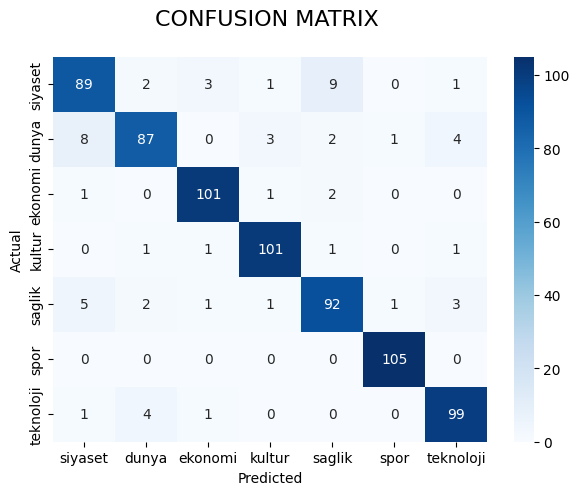

In [106]:
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='d',
            xticklabels=targets,
            yticklabels=targets)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX \n", size=16);

In [107]:
small_test_data = [
 {"text":"""Son yıllarda internetin en fazla konuşulan kişilerinden olan Bryan Johnson, kendini ölümsüz kılmak amacıyla oluşturduğu akıl almaz
 beslenme ve sağlık rutiniyle gündemden düşmüyor. Kendi bedeni üzerinde yapabileceği deneylerin sonuna gelen Johnson, programını daha fazla kişiye açtı
 ve çok kısa sürede büyük ilgi gördü. Peki bilim insanları ve doktorların eleştiri ve uyarılarına konu olan bu programda ne var?
 Neden tüm uyarılara rağmen Johnson'ın protokolünü bu kadar popüler oldu?""",
 "category":"dunya"},
 {"text":"""Ağız ve diş sağlığının bozulması sonucunda meydana gelen diş kayıpları, konuşma ve kelimeleri telaffuz etmede zorluk yaşattığı gibi sindirim
 sisteminde sorunlara da neden oluyor. Ama hepsi bu değil. Uzmanlara göre dişte oluşan problemler başta kalp rahatsızlıkları olmak üzere akciğer hastalıkları,
  diyabet hatta son araştırmalara göre Alzheimer’ın oluşmasında etkili. Peki dişlerin bu hastalıklarla ilgisi ne? Ağız hijyeni bu sorunların önüne geçmede
  ne kadar etkili?
 Uzmanlarla mercek altına aldık.""",
  "category":"saglik"},
 {"text":"""Bundan yaklaşık 30 yıl önce yapay zekânın hayatımızın her alanına gireceğini, bağışıklık sistemi hücrelerinin kanser tedavisinde
 kilit yöntem olacağını, beyin hücresi atlası çıkarılacağını, gen tedavilerinin yaygınlaşacağını ve uzay turizmi gibi kavramlardan bahsedeceğimizi söyleseler
  bir bilimkurgu filminden bahsedildiğini düşünürdük. Yaşadığımız aşırı doğa olaylarına ve iklim krizine bakarsak da bunun distopik bir film olacağını
  zannederdik. 2023 yılı özellikle sağlık alanındaki bilimsel gelişmeler yönünden verimli ancak doğaya verdiğimiz tahribat açısından umutsuz geçti.
 Peki, 2024’te ve sonraki dönemde bizi neler bekliyor? Bilim insanlarına sorduk.""" ,
 "category":"teknoloji"},
 {"text":"""Trendyol Süper Lig'in 21. haftasında deplasmanda Trabzonspor ile karşılaşacak olan Galatasaray'da kafile açıklandı. Mauro Icardi kadroda yer aldı.
Süper Lig'in 21. haftasında yarın deplasmanda Trabzonspor ile karşı karşıya gelecek olan Galatasaray'da kafile kadrosu belli oldu. İki gündür takımla çalışan Mauro Icardi kadroda yer aldı.""",
  "category":"spor"},
 {"text": """Milyonlarca memur ve emekli maaş zammının yüzde 49.25 olarak belirlenmesinin ardından maaş farklarını beklemeye başladı.
 Memur ve memur emeklileri,
  zamlı maaşlarını ve enflasyon farkları 15 Ocak'tan itibaren alacak.
  """,
  "category":"ekonomi"}

]
test_df = pd.DataFrame(small_test_data)

In [122]:
predicts = []
for i,row in test_df.iterrows():
  text = preprocess_for_training(row["text"])
  _,probs = model.predict(text)
  pred_id = np.argmax(probs,axis=1)[0]
  pred = id_to_category[pred_id]
  predicts.append(pred)
test_df["preds"] = predicts


  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/462 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/639 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/327 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [123]:
test_df

,text,category,preds
0,Son yıllarda internetin en fazla konuşulan kiş...,dunya,saglik
1,Ağız ve diş sağlığının bozulması sonucunda mey...,saglik,saglik
2,Bundan yaklaşık 30 yıl önce yapay zekânın haya...,teknoloji,teknoloji
3,Trendyol Süper Lig'in 21. haftasında deplasman...,spor,spor
4,Milyonlarca memur ve emekli maaş zammının yüzd...,ekonomi,ekonomi
